In [50]:
import os, glob, sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from Model_Comparing import KNeighborsRegressor_Model

In [51]:
if os.path.exists('Dataset for Model'): pass
else: os.mkdir('Dataset for Model')

In [52]:
Stock_Data = pd.read_csv(os.path.join('Dataset for Model', 'All Stocks Dataset.csv'), header = 0)
for i in range(Stock_Data.shape[1]):
    if Stock_Data.iloc[:, i].isnull().sum() > 0:
        Stock_Data[Stock_Data.columns[i]] = Stock_Data[Stock_Data.columns[i]].fillna(Stock_Data[Stock_Data.columns[i]].mean())       
Stock_Data['Date'] = pd.to_datetime(Stock_Data['Date'])

In [53]:
class SQLite3:
    def __init__(self, Dataset , Name):
        self.Dataset = Dataset
        self.Name = Name
        
    def SQLite3_Connection(self):
        if self.Name + ".db" not in glob.glob("*db"):
            Connection = sqlite3.connect(self.Name + ".db")
            self.Dataset.to_sql(self.Name, Connection, if_exists='replace', index=False)
            print("Database already created!")
            return Connection
        else: return sqlite3.connect(self.Name + ".db")

    def Exc(self, Query):
        Connection = self.SQLite3_Connection()
        return pd.read_sql_query(Query, Connection)

Table_Name = 'Stock Market Data'
Conn = SQLite3(Stock_Data, Table_Name)
Query = f"""
    SELECT * 
    FROM '{Table_Name}'
"""        
Conn.Exc(Query)

,Date,Open,High,Low,Close,Volume,Name
0,2013-02-08 00:00:00,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11 00:00:00,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12 00:00:00,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13 00:00:00,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14 00:00:00,14.94,14.96,13.16,13.99,31879900,AAL
...,...,...,...,...,...,...,...
619035,2018-02-01 00:00:00,76.84,78.27,76.69,77.82,2982259,ZTS
619036,2018-02-02 00:00:00,77.53,78.12,76.73,76.78,2595187,ZTS
619037,2018-02-05 00:00:00,76.64,76.92,73.18,73.83,2962031,ZTS
619038,2018-02-06 00:00:00,72.74,74.56,72.13,73.27,4924323,ZTS


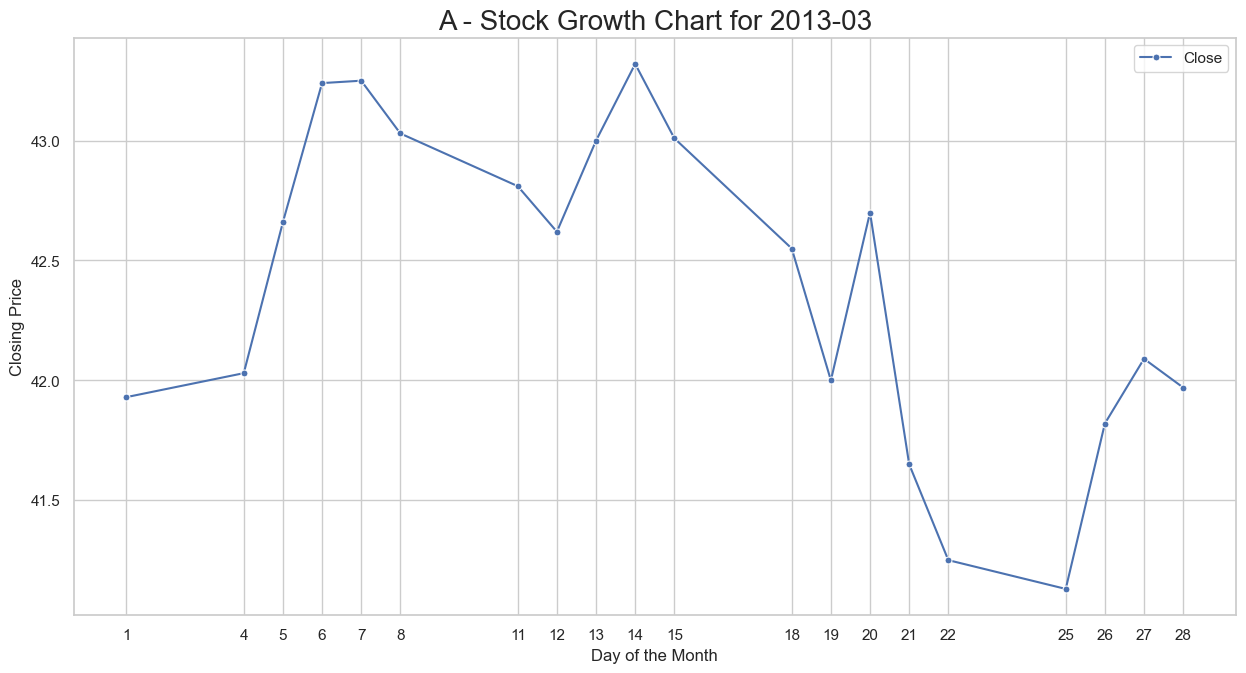

In [54]:
Stock_Data['Day'] = Stock_Data['Date'].dt.day
Stock_Data['Month'] = Stock_Data['Date'].dt.month
Stock_Data['Year_Month'] = Stock_Data['Date'].dt.to_period('M').astype(str)

def Growth_Rate(Name, Month, Year):
    # Lọc dữ liệu theo tên cổ phiếu, tháng và năm
    Growth_Rate_Of_Stock = Stock_Data[(Stock_Data['Name'] == Name) & 
                                       (Stock_Data['Month'] == Month) & 
                                       (Stock_Data['Date'].dt.year == Year)]
    
    # Kiểm tra xem có dữ liệu nào không
    if Growth_Rate_Of_Stock.empty:
        print("No data available for the specified month and year.")
        return

    # Vẽ biểu đồ
    plt.figure(figsize=(15, 7.5))
    sns.set_theme(style="whitegrid")
    sns.lineplot(data=Growth_Rate_Of_Stock, x='Day', y='Close', label='Close', marker='o', markersize=5)
    
    # Thêm tiêu đề và nhãn cho các trục
    plt.title(f'{Name} - Stock Growth Chart for {Year}-{Month:02d}', fontsize=20)
    plt.xlabel('Day of the Month', fontsize=12)
    plt.ylabel('Closing Price', fontsize=12)
    
    # Thiết lập trục x để hiển thị các ngày dưới dạng số nguyên
    plt.xticks(ticks=Growth_Rate_Of_Stock['Day'], labels=Growth_Rate_Of_Stock['Day'], rotation=0)
    
Growth_Rate('A', 3, 2013)

In [56]:
def LinearRegression_Model(Stock_Data, Name):
    Stock = Stock_Data.loc[Stock_Data['Name'] == Name]    
    X = Stock[['Open', 'High', 'Low', 'Volume']]
    Y = Stock['Close']
    
    # Chia dữ liệu thành train và test
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    
    # Huấn luyện mô hình Linear Regression
    Model = LinearRegression().fit(X_train, Y_train)
    
    # Dự đoán trên tập kiểm tra
    Predictions = Model.predict(X_test)
    
    # Tạo DataFrame để lưu kết quả
    Test_Dates = Stock_Data.loc[Y_test.index, 'Date']
    Results = pd.DataFrame({
        'Date': Test_Dates,
        'Actual': Y_test.values,
        'Predicted': Predictions
    })
    
    # Dự đoán xu hướng
    Results['Trend Prediction'] = np.where(Results['Predicted'].diff() > 0, 'Increase', 'Decrease')
    Results['Trend Actual'] = np.where(Results['Actual'].diff() > 0, 'Increase', 'Decrease')  
      
    # Tính độ chính xác
    Accuracy = (Results['Trend Prediction'] == Results['Trend Actual']).mean()
    print(f'Accuracy of trend prediction: {Accuracy:.2%}')

    return Results.sort_values(by='Date').reset_index(drop=True), Model


In [57]:
new_data = pd.DataFrame({
    'Open': [15.07],
    'High': [25.12],
    'Low': [14.63],
    'Volume': [9407500]
})

LinearRegression_Model_Results, LinearRegression_Model = LinearRegression_Model(Stock_Data, 'A')
Predicted_Price = LinearRegression_Model.predict(new_data)

print(f'Close predict for New Data: {Predicted_Price[0]}')

Accuracy of trend prediction: 99.21%
Close predict for New Data: 22.795335698175204


In [58]:
LinearRegression_Model_Results

,Date,Actual,Predicted,Trend Prediction,Trend Actual
0,2013-02-25,41.29,41.521165,Decrease,Decrease
1,2013-03-14,43.32,43.275635,Decrease,Decrease
2,2013-03-22,41.25,41.002354,Decrease,Decrease
3,2013-03-26,41.82,41.672331,Increase,Increase
4,2013-03-27,42.09,41.866249,Decrease,Decrease
...,...,...,...,...,...
247,2018-01-22,73.48,73.031505,Increase,Increase
248,2018-01-25,73.86,74.029862,Increase,Increase
249,2018-01-30,72.99,73.226936,Increase,Increase
250,2018-02-02,71.25,71.809453,Increase,Increase


In [59]:
KNeighborsRegressor_Model_Results, KNeighborsRegressor_Model = KNeighborsRegressor_Model(Stock_Data, 'A')
Predicted_Price = KNeighborsRegressor_Model.predict(new_data)

print(f'Close predict for New Data: {Predicted_Price[0]}')

Accuracy of trend prediction: 61.51%
Close predict for New Data: 48.23616470588236
